In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import itertools
from scipy.stats import pearsonr, spearmanr
from IPython.display import display

In [2]:
EXPERIMENT_DICT = {"augmentation_test":     ["Normal", "Augmentation_25", "Augmentation_50", "Augmentation_75", "Augmentation_100"],
                   "shortcut_test": ["Shortcut_0", "Shortcut_25", "Shortcut_50", "Shortcut_75", "Shortcut_100"],
                   "label_test":    ["Normal", "RandomLabels_25", "RandomLabels_50", "RandomLabels_75", "RandomLabels_100"],
                   "layer_test":    ["MultiLayer"],
                   "standard_test": ["Normal"],
}

In [3]:
EXPERIMENTS = list(EXPERIMENT_DICT.keys())
DATASETS = ["cora", "flickr", "ogbn-arxiv"]
ARCHITECTURES = ["GCN", "GraphSAGE", "GAT"]

In [4]:
MEASURE_NAME_DICT = {
    "AlignedCosineSimilarity": "AlignCos",
    "CKA": "CKA",
    "ConcentricityDifference": "ConcDiff",
    "DistanceCorrelation": "DistCorr",
    "EigenspaceOverlapScore": "EOS",
    "GeometryScore": "GS",
    "Gulp": "GULP",
    "HardCorrelationMatch": "HardCorr",
    "IMDScore": "IMD",
    "JaccardSimilarity": "Jaccard",
    "LinearRegression": "LinReg",
    "MagnitudeDifference": "MagDiff",
    "OrthogonalAngularShapeMetricCentered": "ShapeMet",
    "OrthogonalProcrustesCenteredAndNormalized": "OrthProc",
    "PWCCA": "PWCCA",
    "PermutationProcrustes": "PermProc",
    "ProcrustesSizeAndShapeDistance": "ProcDist",
    "RSA": "RSA",
    "RSMNormDifference": "RSMDiff",
    "RankSimilarity": "RankSim",
    "SVCCA": "SVCCA",
    "SecondOrderCosineSimilarity": "2nd-Cos",
    "SoftCorrelationMatch": "SoftCorr",
    "UniformityDifference": "UnifDiff",
}

ABBR_DICT = {
    "cora": "Cora",
    "flickr": "Flickr",
    "ogbn-arxiv": "OGBN-Arxiv",
    "GraphSAGE": "SAGE",
    "GCN": "GCN",
    "GAT": "GAT",
    "PGNN": "PGNN",
}

COLUMN_NAME_DICT = {
    "similarity_measure": "Similarity Measure", 
    "quality_measure": "Measure",
    "functional_similarity_measure": "Measure",
    "architecture": "Model",
    "representation_dataset": "Dataset"
}

LATEX_FORMAT_DICT = {
    "float_format": "%.2f", 
    "column_format": "l||rrr|rrr|rrr||rrr|rrr|rrr",
    "multicolumn_format": "c",
    "index_names": False,
}

In [5]:
def agg_train_results(exp, dataset, architecture):
    res_path = os.path.join("C:/Users/Tobias/Eigene Dokumente/Research/similaritybench/experiments/models/graphs", dataset, architecture)
    res_list = []
    res_csvs = [f"train_results_s{s}.csv" for s in range(5)]
    for setting in EXPERIMENT_DICT[exp]:
        setting_path = os.path.join(res_path, setting)
        n_runs = 0
        setting_results = np.zeros(3)
        for fname in res_csvs:
            curr_df = pd.read_csv(os.path.join(setting_path,fname)).iloc[:,-3:]
            curr_results = np.array(curr_df.iloc[-1])
            setting_results += curr_results
            n_runs+=1
        setting_results /= n_runs
        res_list.append([setting, architecture] + list(setting_results))
    df_res = pd.DataFrame(data=res_list, columns = ["Setting", "Architecture", "Train", "Val", "Test"])
    return df_res

In [6]:
def get_data_table(experiment, dataset, architectures=["GCN", "GraphSAGE", "GAT"]):
    data_list = []
    for arch in architectures:
        data_list.append(agg_train_results(experiment, dataset, arch))
    res_df = pd.concat(data_list)
    res_df = res_df.pivot(index="Setting", columns=["Architecture"])
    return res_df.reindex(EXPERIMENT_DICT[experiment])[["Train", "Val", "Test"]].swaplevel(axis=1).sort_index(axis=1, level=0).reindex(columns=["Train", "Val", "Test"], level=1)

In [7]:
def agg_train_results(architecture, dataset, exp):
    res_path = os.path.join("C:/Users/Tobias/Eigene Dokumente/Research/similaritybench/experiments/models/graphs", dataset, architecture)
    
    if exp == "standard_test":
        n_seeds = 10
    else:
        n_seeds = 5
        
    dfs = []
    for setting in EXPERIMENT_DICT[exp]:
        setting_path = os.path.join(res_path, setting)

        splits = ["Train", "Val", "Test"]
        setting_results = np.zeros(3)
        all_results = []
        split_cols = []
        seed_cols = []
        for s in range(n_seeds):
            fname = f"train_results_s{s}.csv"
            curr_df = pd.read_csv(os.path.join(setting_path,fname)).iloc[:,-3:]
            curr_results = np.array(curr_df.iloc[-1])
            all_results += list(curr_results)
            split_cols += ["Train", "Val", "Test"]
            seed_cols += [s]*3
        
        df_res = pd.DataFrame(data=np.array([seed_cols,split_cols,all_results]).T, columns = ["Seed", "Split", "Accuracy"])
        df_res["Accuracy"] = df_res["Accuracy"].astype(float)
        df_res["Architecture"] = ABBR_DICT[architecture]
        df_res["Dataset"] = ABBR_DICT[dataset]
        df_res["Setting"] = setting
        dfs.append(df_res)

    return pd.concat(dfs, axis=0)

In [8]:
def all_results_long(experiment):
    dfs = []
    for dataset, architecture in itertools.product(DATASETS, ARCHITECTURES):
        dfs.append(agg_train_results(architecture, dataset, experiment))
    if experiment != "augmentation_test":
        dfs.append(agg_train_results("PGNN", "cora", experiment))
    return pd.concat(dfs, axis=0, ignore_index=True) 

In [9]:
df_normal=all_results_long("standard_test")

In [10]:
sns.set_theme("paper", style="whitegrid", font_scale=1.5)

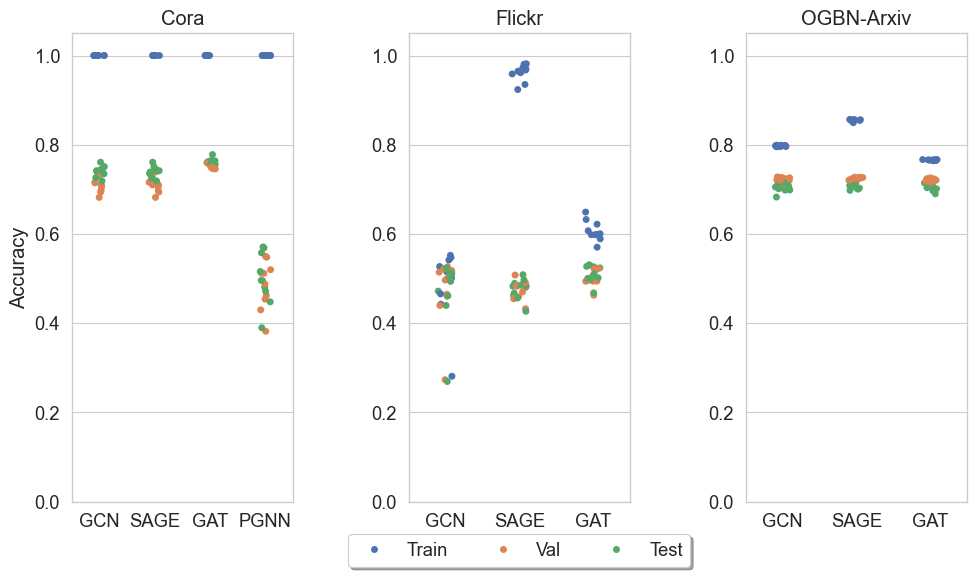

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.stripplot(
    data=df_normal.loc[df_normal.Dataset == "Cora"], x="Architecture", y="Accuracy", hue="Split", ax = axes[0], legend=False, # palette=palette,
)
axes[0].set_title("Cora")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("")
axes[0].set_ylim((0,1.05))
ax = axes[0]
handles, labels = ax.get_legend_handles_labels()

sns.stripplot(
   data=df_normal.loc[df_normal.Dataset == "Flickr"], x="Architecture", y="Accuracy", hue="Split", ax = axes[1], legend=True,
)
axes[1].set_title("Flickr")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_ylim((0,1.05))
ax = axes[1]
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)

sns.stripplot(
   data=df_normal.loc[df_normal.Dataset == "OGBN-Arxiv"], x="Architecture", y="Accuracy", hue="Split", ax = axes[2], legend=False
)
axes[2].set_title("OGBN-Arxiv")
axes[2].set_ylabel("")
axes[2].set_ylim((0,1.05))
axes[2].set_xlabel("")
# axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# handles, labels = ax.get_legend_handles_labels()
#ax.set_xticklabels(xticklabels)
plt.tight_layout()
fig.savefig("graphs_splits.pdf", bbox_inches="tight")

In [12]:
df_shortcut=all_results_long("shortcut_test")

In [13]:
df_shortcut = df_shortcut.loc[(df_shortcut.Split=="Test") & df_shortcut.Setting.isin(["Shortcut_0", "Shortcut_50", "Shortcut_100"])]

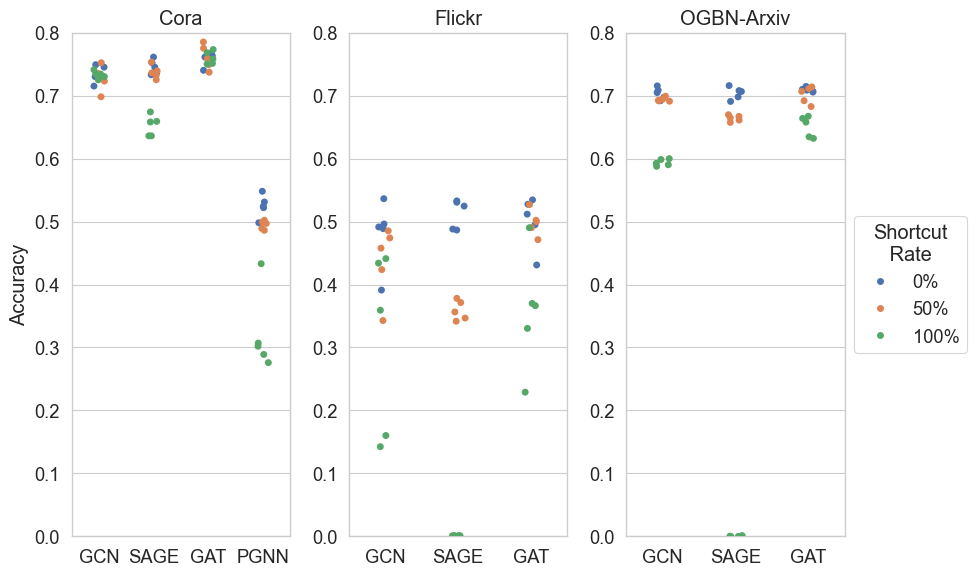

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.stripplot(
    data=df_shortcut.loc[df_shortcut.Dataset == "Cora"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[0], legend=False, # palette=palette,
)
axes[0].set_title("Cora")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("")
axes[0].set_ylim((0,0.8))
ax = axes[0]
handles, labels = ax.get_legend_handles_labels()

sns.stripplot(
   data=df_shortcut.loc[df_shortcut.Dataset == "Flickr"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[1], legend=False,
)
axes[1].set_title("Flickr")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_ylim((0,0.8))
ax = axes[1]
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=4)

sns.stripplot(
   data=df_shortcut.loc[df_shortcut.Dataset == "OGBN-Arxiv"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[2], legend=True
)
axes[2].set_title("OGBN-Arxiv")
axes[2].set_ylabel("")
axes[2].set_ylim((0,0.8))
axes[2].set_xlabel("")

ax = axes[2]
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2]]
labels = ["0%", "50%", "100%"]
ax.legend(handles=handles, labels=labels, loc='center left', title = "Shortcut\n   Rate", bbox_to_anchor=(1, 0.5))
# handles, labels = ax.get_legend_handles_labels()
#ax.set_xticklabels(xticklabels)
plt.tight_layout()
fig.savefig("graphs_shortcuts.pdf", bbox_inches="tight")

In [15]:
df_label=all_results_long("label_test")

In [16]:
df_label = df_label.loc[(df_label.Split=="Test") & df_label.Setting.isin(["Normal", "RandomLabels_25", "RandomLabels_100"])]

In [17]:
df_label

,Seed,Split,Accuracy,Architecture,Dataset,Setting
2,0,Test,0.745,GCN,Cora,Normal
5,1,Test,0.761,GCN,Cora,Normal
8,2,Test,0.715,GCN,Cora,Normal
11,3,Test,0.739,GCN,Cora,Normal
14,4,Test,0.751,GCN,Cora,Normal
...,...,...,...,...,...,...
737,0,Test,0.140,PGNN,Cora,RandomLabels_100
740,1,Test,0.149,PGNN,Cora,RandomLabels_100
743,2,Test,0.149,PGNN,Cora,RandomLabels_100
746,3,Test,0.155,PGNN,Cora,RandomLabels_100


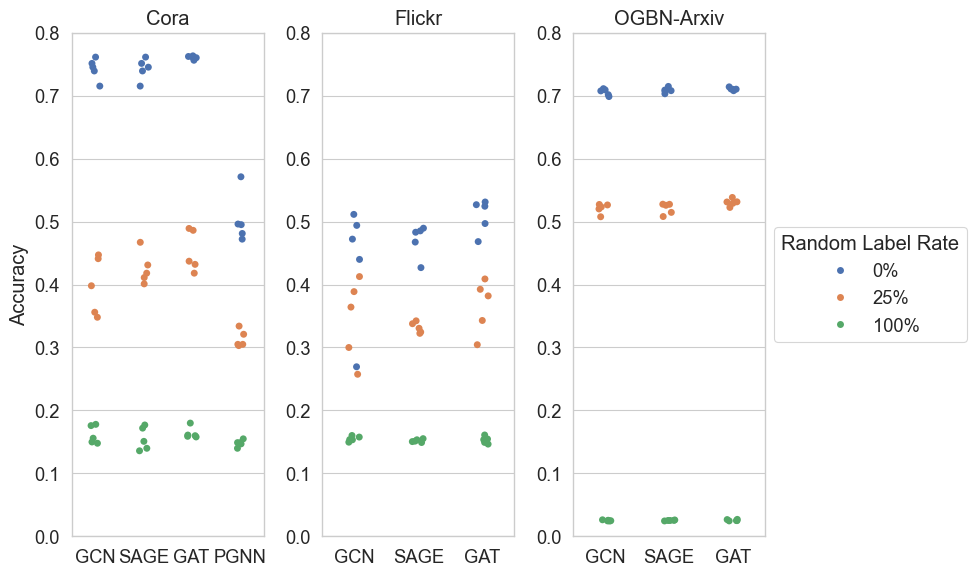

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.stripplot(
    data=df_label.loc[df_label.Dataset == "Cora"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[0], legend=False, # palette=palette,
)
axes[0].set_title("Cora")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("")
axes[0].set_ylim((0,0.8))
ax = axes[0]
handles, labels = ax.get_legend_handles_labels()

sns.stripplot(
   data=df_label.loc[df_label.Dataset == "Flickr"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[1], legend=False,
)
axes[1].set_title("Flickr")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_ylim((0,0.8))
ax = axes[1]
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=4)

sns.stripplot(
   data=df_label.loc[df_label.Dataset == "OGBN-Arxiv"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[2], legend=True
)
axes[2].set_title("OGBN-Arxiv")
axes[2].set_ylabel("")
axes[2].set_ylim((0,0.8))
axes[2].set_xlabel("")

ax = axes[2]
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2]]
labels = ["0%", "25%", "100%"]
ax.legend(handles=handles, labels=labels, loc='center left', title = "Random Label Rate", bbox_to_anchor=(1, 0.5))
# handles, labels = ax.get_legend_handles_labels()
#ax.set_xticklabels(xticklabels)
plt.tight_layout()
fig.savefig("graphs_labels.pdf", bbox_inches="tight")

In [19]:
df_aug=all_results_long("augmentation_test")

In [20]:
df_aug = df_aug.loc[(df_label.Split=="Test") & df_aug.Setting.isin(["Normal", "Augmentation_25", "Augmentation_100"])]

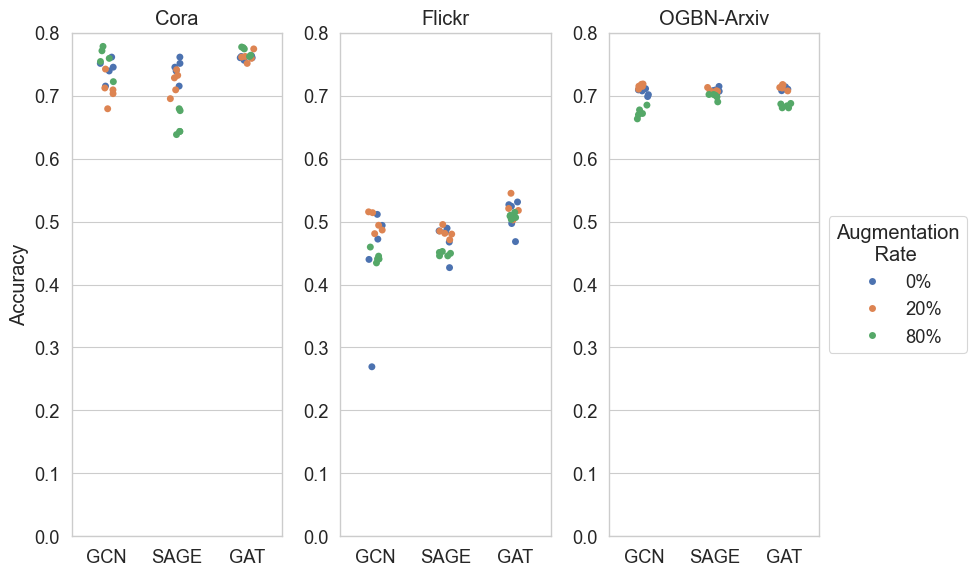

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.stripplot(
    data=df_aug.loc[df_aug.Dataset == "Cora"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[0], legend=False, # palette=palette,
)
axes[0].set_title("Cora")
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("")
axes[0].set_ylim((0,0.8))
ax = axes[0]
handles, labels = ax.get_legend_handles_labels()

sns.stripplot(
   data=df_aug.loc[df_aug.Dataset == "Flickr"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[1], legend=False,
)
axes[1].set_title("Flickr")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_ylim((0,0.8))
ax = axes[1]
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=4)

sns.stripplot(
   data=df_aug.loc[df_aug.Dataset == "OGBN-Arxiv"], x="Architecture", y="Accuracy", hue="Setting", ax = axes[2], legend=True
)
axes[2].set_title("OGBN-Arxiv")
axes[2].set_ylabel("")
axes[2].set_ylim((0,0.8))
axes[2].set_xlabel("")

ax = axes[2]
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[2]]
labels = ["0%", "20%", "80%"]
ax.legend(handles=handles, labels=labels, loc='center left', title = "Augmentation\n       Rate", bbox_to_anchor=(1, 0.5))
# handles, labels = ax.get_legend_handles_labels()
#ax.set_xticklabels(xticklabels)
plt.tight_layout()
fig.savefig("graphs_augmented.pdf", bbox_inches="tight")